In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load Dataset from Excel
data = pd.read_excel('dataKasus-1.xlsx')  # Memuat dataset dari file Excel
print("Data Loaded Successfully!")
print("Info Data:", data.info())
print("Beberapa data awal:\n", data.head())

Data Loaded Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   NO                                561 non-null    int64 
 1   NAMA                              561 non-null    object
 2   USIA                              558 non-null    object
 3   PARITAS                           561 non-null    int64 
 4   JARAK KELAHIRAN                   554 non-null    object
 5   RIW HIPERTENSI                    561 non-null    object
 6   RIW PE                            561 non-null    object
 7   OBESITAS                          561 non-null    object
 8   RIW DM                            561 non-null    object
 9   RIW HIPERTENSI/PE DALAM KELUARGA  561 non-null    object
 10  SOSEK RENDAH                      561 non-null    object
 11  PE/Non PE                         561 non-null    object
 

In [3]:
# Data Preprocessing
print("\n---Data Preprocessing---")
# Drop irrelevant columns
data_cleaned = data.drop(columns=['NO', 'NAMA', 'Unnamed: 12'])


---Data Preprocessing---


In [4]:
# Handle missing values by filling with the most frequent value (mode)
data_cleaned['USIA'] = data_cleaned['USIA'].fillna(data_cleaned['USIA'].mode()[0])
data_cleaned['JARAK KELAHIRAN'] = data_cleaned['JARAK KELAHIRAN'].fillna(data_cleaned['JARAK KELAHIRAN'].mode()[0])

In [5]:
# Isi nilai NaN dengan modus terlebih dahulu untuk menghindari masalah konversi
data_cleaned['USIA'] = data_cleaned['USIA'].fillna(data_cleaned['USIA'].mode()[0])

# Remove non-numeric characters (like " TH") in the 'USIA' column
data_cleaned['USIA'] = data_cleaned['USIA'].str.extract(r'(\d+)')

# Pastikan tidak ada nilai NaN setelah proses ekstraksi angka
data_cleaned['USIA'] = data_cleaned['USIA'].fillna(data_cleaned['USIA'].mode()[0])

# Konversi ke tipe integer setelah memastikan tidak ada NaN
data_cleaned['USIA'] = data_cleaned['USIA'].astype(int)

In [6]:
# Encode categorical data
label_encoders = {}
for column in data_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

In [7]:
# Splitting data into Features (X) and Target (y)
target_column_name = 'PE/Non PE'
X = data_cleaned.drop(target_column_name, axis=1)
y = data_cleaned[target_column_name]


---Exploratory Data Analysis---
Descriptive Statistics:
              USIA     PARITAS  JARAK KELAHIRAN  RIW HIPERTENSI      RIW PE  \
count  561.000000  561.000000       561.000000      561.000000  561.000000   
mean    28.190731    1.709447         2.183601        0.094474    8.795009   
std      5.858844    1.012105         1.012501        0.292748    0.974154   
min     13.000000    0.000000         0.000000        0.000000    0.000000   
25%     24.000000    1.000000         2.000000        0.000000    9.000000   
50%     28.000000    2.000000         2.000000        0.000000    9.000000   
75%     32.000000    2.000000         3.000000        0.000000    9.000000   
max     43.000000    6.000000         3.000000        1.000000   10.000000   

         OBESITAS      RIW DM  RIW HIPERTENSI/PE DALAM KELUARGA  SOSEK RENDAH  \
count  561.000000  561.000000                        561.000000    561.000000   
mean     0.008913    0.008913                          0.980392      0.992870

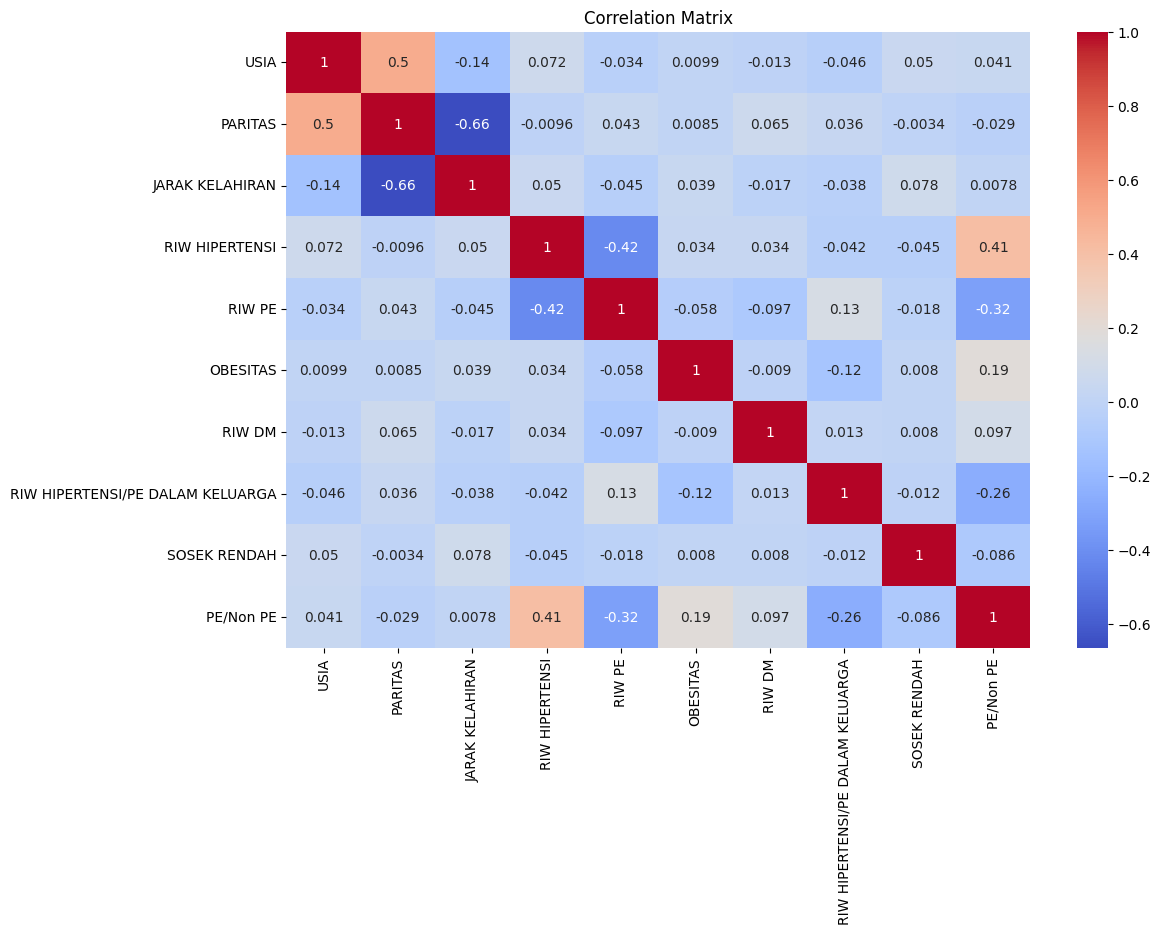

In [8]:
# Exploratory Data Analysis (EDA)
print("\n---Exploratory Data Analysis---")
print("Descriptive Statistics:\n", data_cleaned.describe())
plt.figure(figsize=(12, 8))
sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

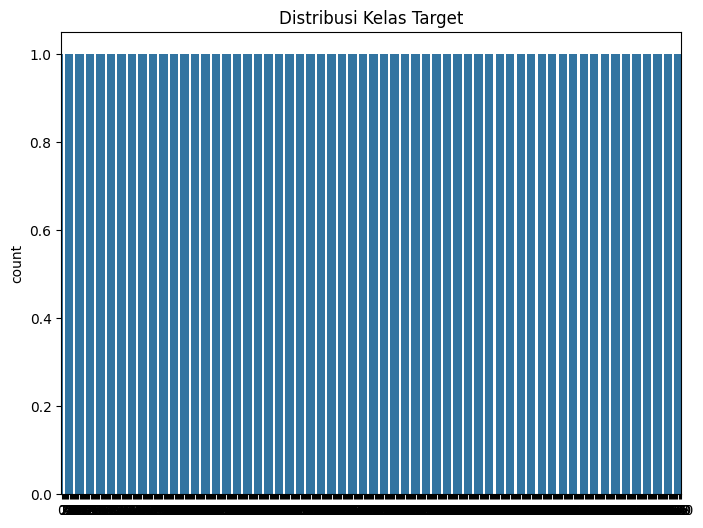

In [9]:
# Visualisasi distribusi variabel target
plt.figure(figsize=(8, 6))
sns.countplot(data_cleaned[target_column_name])
plt.title("Distribusi Kelas Target")
plt.show()

In [10]:
# Feature Selection (15 AH) using Recursive Feature Elimination (RFE)
print("\n---Feature Selection---")
model = DecisionTreeClassifier(random_state=42)
selector = RFE(model, n_features_to_select=15, step=1)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)


---Feature Selection---
Selected Features: Index(['USIA', 'PARITAS', 'JARAK KELAHIRAN', 'RIW HIPERTENSI', 'RIW PE',
       'OBESITAS', 'RIW DM', 'RIW HIPERTENSI/PE DALAM KELUARGA',
       'SOSEK RENDAH'],
      dtype='object')


C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=15 > n_features=9. There will be no feature selection and all features will be kept.
  warnings.warn(


In [11]:
# Train-test split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_selected, X_test_selected, _, _ = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [12]:
# Standardize data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_full = scaler.transform(X_test_full)
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

In [13]:
# Modeling and Evaluation with Cross-Validation
print("\n---Modeling and Evaluation---")
models = {
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Initialize dictionaries to store scores
scores_full = {}
scores_selected = {}

for name, model in models.items():
    # Original Data
    print(f"\nModel: {name} on Original Data")
    model.fit(X_train_full, y_train)
    y_pred_full = model.predict(X_test_full)
    cm_full = confusion_matrix(y_test, y_pred_full)
    print("Confusion Matrix (Original):\n", cm_full)
    print("Classification Report (Original):\n", classification_report(y_test, y_pred_full))
    cv_scores_full = cross_val_score(model, X_train_full, y_train, cv=5)
    scores_full[name] = (cv_scores_full.mean(), cv_scores_full.std())
    
    # Selected Data
    print(f"\nModel: {name} on Selected Features")
    model.fit(X_train_selected, y_train)
    y_pred_selected = model.predict(X_test_selected)
    cm_selected = confusion_matrix(y_test, y_pred_selected)
    print("Confusion Matrix (Selected):\n", cm_selected)
    print("Classification Report (Selected):\n", classification_report(y_test, y_pred_selected))
    cv_scores_selected = cross_val_score(model, X_train_selected, y_train, cv=5)
    scores_selected[name] = (cv_scores_selected.mean(), cv_scores_selected.std())


---Modeling and Evaluation---

Model: Naive Bayes on Original Data
Confusion Matrix (Original):
 [[ 0 82  0  4 16]
 [ 0  2  0  0  4]
 [ 0  1  0  0  0]
 [ 0  0  0  0  0]
 [ 1  1  0  0  2]]
Classification Report (Original):
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       102
           2       0.02      0.33      0.04         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.09      0.50      0.15         4

    accuracy                           0.04       113
   macro avg       0.02      0.17      0.04       113
weighted avg       0.00      0.04      0.01       113


Model: Naive Bayes on Selected Features
Confusion Matrix (Selected):
 [[ 0 82  0  4 16]
 [ 0  2  0  0  4]
 [ 0  1  0  0  0]
 [ 0  0  0  0  0]
 [ 1  1  0  0  2]]
Classification Report (Selected):
               precision    recall  f1-score   support

           1       0.00      0.00  

C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

Classification Report (Selected):
               precision    recall  f1-score   support

           1       0.93      0.97      0.95       102
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         4

    accuracy                           0.88       113
   macro avg       0.23      0.24      0.24       113
weighted avg       0.84      0.88      0.86       113


Model: Decision Tree on Original Data
Confusion Matrix (Original):
 [[99  2  0  1]
 [ 4  0  0  2]
 [ 0  1  0  0]
 [ 3  0  0  1]]
Classification Report (Original):
               precision    recall  f1-score   support

           1       0.93      0.97      0.95       102
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           5       0.25      0.25      0.25         4

    accuracy                           0.88       113
   macro avg       0.30      0.31      

C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\terate\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [14]:
# Comparison Analysis
print("\n---Comparison Analysis---")
for name in models.keys():
    print(f"{name}:")
    print(f"Original Data - Mean CV Score: {scores_full[name][0]:.4f} ± {scores_full[name][1]:.4f}")
    print(f"Selected Data - Mean CV Score: {scores_selected[name][0]:.4f} ± {scores_selected[name][1]:.4f}")
    print()


---Comparison Analysis---
Naive Bayes:
Original Data - Mean CV Score: 0.0313 ± 0.0110
Selected Data - Mean CV Score: 0.0313 ± 0.0110

K-Nearest Neighbors:
Original Data - Mean CV Score: 0.9420 ± 0.0107
Selected Data - Mean CV Score: 0.9420 ± 0.0107

Decision Tree:
Original Data - Mean CV Score: 0.9353 ± 0.0080
Selected Data - Mean CV Score: 0.9353 ± 0.0080



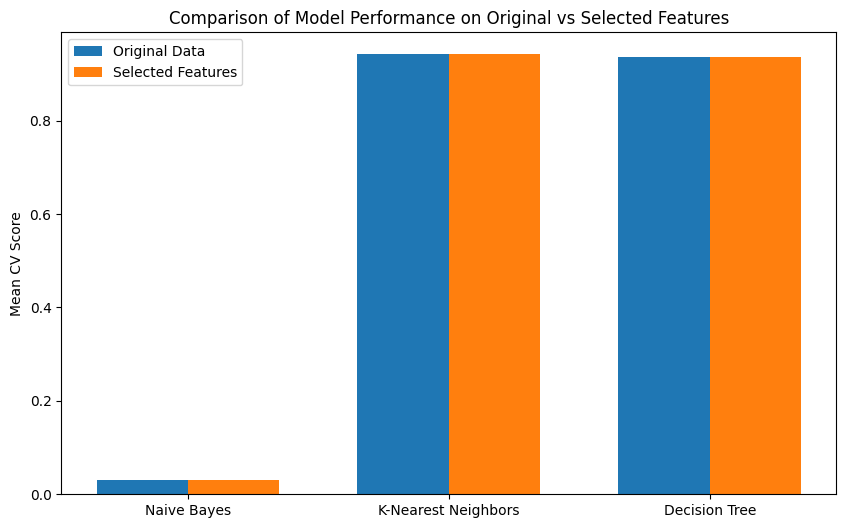

In [15]:
# Visualisasi Hasil
labels = list(models.keys())
original_scores = [scores_full[model][0] for model in labels]
selected_scores = [scores_selected[model][0] for model in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, original_scores, width, label='Original Data')
rects2 = ax.bar(x + width/2, selected_scores, width, label='Selected Features')

ax.set_ylabel('Mean CV Score')
ax.set_title('Comparison of Model Performance on Original vs Selected Features')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()